In [16]:
import pandas as pd
import spacy
import networkx as nx
import re
import nltk
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

In [17]:
NER = spacy.load("en_core_web_sm")
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jamesrobertson/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [18]:
with open('tories.txt', 'r') as f:
    text_data_raw = f.readlines()

text_data = []

for i in text_data_raw:
    split = i.split('.')
    for j in split:
        if j.strip() != '\n' and j.strip():
            text_data.append(j.strip())

text_data

['And what we Conservatives want is more British success stories—and that is what our manifesto will deliver',
 'Now the last few years have been some of the toughest our country has faced in decades',
 "We were hit by Covid and then the spike in energy prices following Putin's invasion of Ukraine",
 'But economic stability is now returning',
 'Inflation - back to normal, real wages have been rising for almost a year now and the economy is growing again',
 'So, the question now is who is best to turn that foundation into a secure future for you, your family and our country',
 'So this manifesto is our clear plan for our United Kingdom',
 'It is about the bold actions we will take to deliver that secure future',
 'We Conservatives know that security is essential for success',
 "And that's why we are raising defence investment to 2",
 '5 percent of GDP by 2030 to deal with the increasingly uncertain world we live in',
 'This is the biggest sustained increase in the defence budget since t

In [19]:
sentences = []
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
G = nx.Graph()

for sent in text_data:
    sent = re.sub(r"[^\w\s]", '', sent)
    sent = word_tokenize(sent)
    sent = [w.lower() for w in sent if not w.lower() in stop_words]
    doc = NER(' '.join(sent))
    sent = [token.text for token in doc if token.pos_ == "NOUN"]
    sent = [lemmatizer.lemmatize(w) for w in sent]
    sent = [w for w in sent if w != 'thats' and w != 'theyre']
    sentences.append(sent)
    length = len(sent)
    for i in range(len(sent)):
        try:
            G.add_edge(sent[i], sent[i+1], weight=3)
            G.add_edge(sent[i], sent[i+2], weight=2)
            G.add_edge(sent[i], sent[i+3], weight=1)
        except:
            pass

/Users/jamesrobertson/miniforge3/envs/textnets/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/Users/jamesrobertson/miniforge3/envs/textnets/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


0.19534997120025052


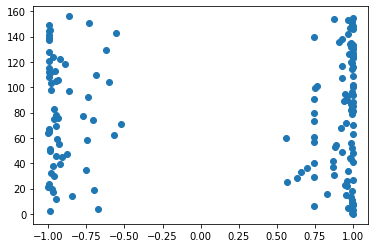

In [26]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")
tory_sent = []

for i in sentences:
    sentiment = sentiment_pipeline(' '.join(i))[0]
    if sentiment['label'] == "NEGATIVE":
        tory_sent.append(-1*sentiment['score'])
    else:
        tory_sent.append(sentiment['score'])

plt.scatter(tory_sent, range(len(tory_sent)))

print(sum(tory_sent) / len(tory_sent))

(array([300.,  10.,   5.,   1.,   1.,   2.,   2.,   0.,   0.,   1.]),
 array([0.        , 0.02180395, 0.04360791, 0.06541186, 0.08721582,
        0.10901977, 0.13082373, 0.15262768, 0.17443164, 0.19623559,
        0.21803955]),
 <BarContainer object of 10 artists>)

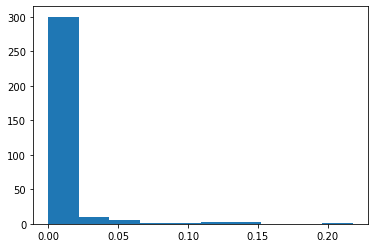

In [20]:
plt.hist(nx.centrality.betweenness_centrality(G).values())

In [27]:
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(
    betweenness_dict, orient="index", columns=['betweenness'])
betweenness_df.sort_values('betweenness', ascending=False)[:10]

,betweenness
people,0.218040
labour,0.150152
security,0.144837
tax,0.117937
country,0.109837
year,0.108182
home,0.072185
energy,0.063409
family,0.062492
time,0.060459


In [22]:
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(
    closeness_dict, orient="index", columns=['centrality'])
closeness_df.sort_values('centrality', ascending=False)

,centrality
people,0.427984
security,0.422512
labour,0.415431
tax,0.409709
year,0.400874
...,...
sex,0.012721
resolve,0.003115
iron,0.003115
emission,0.003115


In [28]:
closeness_dict = nx.degree_centrality(G)
closeness_df = pd.DataFrame.from_dict(
    closeness_dict, orient="index", columns=['centrality'])
closeness_df.sort_values('centrality', ascending=False)[:10]

,centrality
people,0.168224
labour,0.140187
tax,0.140187
security,0.127726
country,0.109034
year,0.102804
energy,0.084112
family,0.071651
time,0.071651
home,0.065421


In [24]:
from pyvis.network import Network
net = Network(width="1200px", height="1000px",
              bgcolor='#222222', font_color='white')

node_degree = dict(G.degree)
closeness_dict = nx.closeness_centrality(G)
betweenness_dict = nx.betweenness_centrality(G)
degree_dict = nx.degree_centrality(G)

# Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')
#nx.set_node_attributes(G, degree_dict, 'degree_centrality')
nx.set_node_attributes(G, betweenness_dict, 'betweenness_centrality')
#nx.set_node_attributes(G, closeness_dict, 'closeness_centrality')

net.from_nx(G)
net.toggle_physics(False)
net.show("tories.html")

In [30]:
import community as community_louvain
communities = community_louvain.best_partition(G)
nx.set_node_attributes(G, communities, 'group')
node_degree = dict(G.degree)
betweenness_dict = nx.betweenness_centrality(G)
degree_dict = nx.degree_centrality(G)

# Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')
nx.set_node_attributes(G, degree_dict, 'degree_centrality')
nx.set_node_attributes(G, betweenness_dict, 'betweenness_centrality')


com_net = Network(notebook=True, width="1200px", height="1000px",
                  bgcolor='#222222', font_color='white')


com_net.from_nx(G)
com_net.toggle_physics(True)
com_net.show("tory_communities.html")